# Cloud Instance Dataset Analysis and Model Training

## Comprehensive Analysis Pipeline for Cloud Instance Optimization

This notebook provides a complete analysis of cloud instance performance data including:
- Data preprocessing and cleaning
- Exploratory Data Analysis (EDA)
- Feature engineering
- Model training (LSTM, Random Forest, XGBoost)
- Model comparison and evaluation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [2]:
# Load the training dataset
train_data = pd.read_csv('dataset/cloud_instance_dataset_enhanced.csv')

print("Dataset Shape:", train_data.shape)
print("\nColumn Names:")
print(train_data.columns.tolist())
print("\nFirst 5 rows:")
train_data.head()

Dataset Shape: (22500, 17)

Column Names:
['CPU_Utilization_Percent', 'Memory_Utilization_Percent', 'Network_In_Mbps', 'Network_Out_Mbps', 'Network_Throughput_Mbps', 'Disk_IO_IOPS', 'Disk_Usage_Percent', 'Response_Time_ms', 'Hourly_Cost_USD', 'Instance_Type', 'Original_Instance_Type', 'Instance_ID', 'Original_Instance_ID', 'Sequence_ID', 'Time_Step', 'Is_Label_Noisy', 'Label_Encoded']

First 5 rows:


,CPU_Utilization_Percent,Memory_Utilization_Percent,Network_In_Mbps,Network_Out_Mbps,Network_Throughput_Mbps,Disk_IO_IOPS,Disk_Usage_Percent,Response_Time_ms,Hourly_Cost_USD,Instance_Type,Original_Instance_Type,Instance_ID,Original_Instance_ID,Sequence_ID,Time_Step,Is_Label_Noisy,Label_Encoded
0,7.683012,14.855094,7.131442,8.093543,11.778249,97.934886,13.488782,242.422862,0.147277,t2.medium,t2.nano,i-t2-medium-59140c12,i-t2-nano-520aa90d,0,0,True,8
1,15.233130,18.233369,5.987482,7.338130,12.703193,109.124839,9.341627,274.130067,0.092997,t2.medium,t2.nano,i-t2-medium-59140c12,i-t2-nano-520aa90d,0,1,True,8
2,19.764660,16.662566,7.617866,7.104918,13.250713,125.323990,20.788045,281.581376,0.001000,t2.medium,t2.nano,i-t2-medium-59140c12,i-t2-nano-520aa90d,0,2,True,8
3,12.636386,13.668974,7.651420,7.200374,15.522448,102.339506,24.603644,328.503307,0.064960,t2.medium,t2.nano,i-t2-medium-59140c12,i-t2-nano-520aa90d,0,3,True,8
4,12.630477,18.283602,6.651047,6.058246,16.424142,108.253482,13.632124,275.649422,0.043873,t2.medium,t2.nano,i-t2-medium-59140c12,i-t2-nano-520aa90d,0,4,True,8


In [3]:
# Basic information about the dataset
print("Dataset Info:")
print(train_data.info())
print("\nDataset Description:")
train_data.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CPU_Utilization_Percent     22500 non-null  float64
 1   Memory_Utilization_Percent  22500 non-null  float64
 2   Network_In_Mbps             22500 non-null  float64
 3   Network_Out_Mbps            22500 non-null  float64
 4   Network_Throughput_Mbps     22500 non-null  float64
 5   Disk_IO_IOPS                22500 non-null  float64
 6   Disk_Usage_Percent          22500 non-null  float64
 7   Response_Time_ms            22500 non-null  float64
 8   Hourly_Cost_USD             22500 non-null  float64
 9   Instance_Type               22500 non-null  object 
 10  Original_Instance_Type      22500 non-null  object 
 11  Instance_ID                 22500 non-null  object 
 12  Original_Instance_ID        22500 non-null  object 
 13  Sequence_ID      

,CPU_Utilization_Percent,Memory_Utilization_Percent,Network_In_Mbps,Network_Out_Mbps,Network_Throughput_Mbps,Disk_IO_IOPS,Disk_Usage_Percent,Response_Time_ms,Hourly_Cost_USD,Sequence_ID,Time_Step,Label_Encoded
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000
mean,56.377888,57.847867,48.958319,48.896559,103.002445,1023.291130,58.916053,118.650431,0.143957,1124.500000,4.500000,7.004889
std,28.788824,27.951904,31.520787,31.480791,72.318587,730.494578,25.409661,83.959879,0.134170,649.533423,2.872345,4.307038
min,2.629561,2.016644,3.245410,3.313344,5.584413,67.902853,2.799853,19.547525,0.001000,0.000000,0.000000,0.000000
25%,26.675659,29.691198,14.671771,14.603569,26.150243,234.011845,33.994181,51.226713,0.021551,562.000000,2.000000,3.000000
50%,64.104412,62.884509,54.622931,54.419293,110.546312,1106.894823,64.187241,74.277488,0.109458,1124.500000,4.500000,7.000000
75%,81.354695,82.451064,72.632574,72.517138,150.776339,1499.523901,80.380906,191.002662,0.236888,1687.000000,7.000000,11.000000
max,100.000000,100.000000,131.390853,134.804832,290.950206,2984.706020,100.000000,617.970304,0.608681,2249.000000,9.000000,14.000000


In [4]:
# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])

# Check data types
print("\nData Types:")
print(train_data.dtypes)

Missing Values:
Series([], dtype: int64)

Data Types:
CPU_Utilization_Percent       float64
Memory_Utilization_Percent    float64
Network_In_Mbps               float64
Network_Out_Mbps              float64
Network_Throughput_Mbps       float64
Disk_IO_IOPS                  float64
Disk_Usage_Percent            float64
Response_Time_ms              float64
Hourly_Cost_USD               float64
Instance_Type                  object
Original_Instance_Type         object
Instance_ID                    object
Original_Instance_ID           object
Sequence_ID                     int64
Time_Step                       int64
Is_Label_Noisy                   bool
Label_Encoded                   int64
dtype: object


## 2. Data Preprocessing

In [5]:
# Handle missing values if any
if train_data.isnull().sum().sum() > 0:
    # Fill numerical missing values with median
    numerical_cols = train_data.select_dtypes(include=[np.number]).columns
    train_data[numerical_cols] = train_data[numerical_cols].fillna(train_data[numerical_cols].median())
    
    # Fill categorical missing values with mode
    categorical_cols = train_data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

print("Missing values after preprocessing:", train_data.isnull().sum().sum())

Missing values after preprocessing: 0


In [6]:
# Identify and separate features
# Based on the visible columns, identifying key features
feature_columns = [
    'CPU_Utilization_Percent', 'Memory_Utilization_Percent', 
    'Network_In_Mbps', 'Network_Out_Mbps', 'Network_Throughput_Disk_IO_IOPS',
    'Disk_Usage_Percent', 'Response_Time_ms'
]

# Identify available columns in the dataset
available_features = [col for col in feature_columns if col in train_data.columns]
print(f"Available feature columns: {available_features}")

# Target variable
target_column = 'Label_Encoded' if 'Label_Encoded' in train_data.columns else train_data.columns[-1]
print(f"Target column: {target_column}")

# Extract features and target
X = train_data[available_features]
y = train_data[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Available feature columns: ['CPU_Utilization_Percent', 'Memory_Utilization_Percent', 'Network_In_Mbps', 'Network_Out_Mbps', 'Disk_Usage_Percent', 'Response_Time_ms']
Target column: Label_Encoded
Features shape: (22500, 6)
Target shape: (22500,)


## 3. Exploratory Data Analysis (EDA)

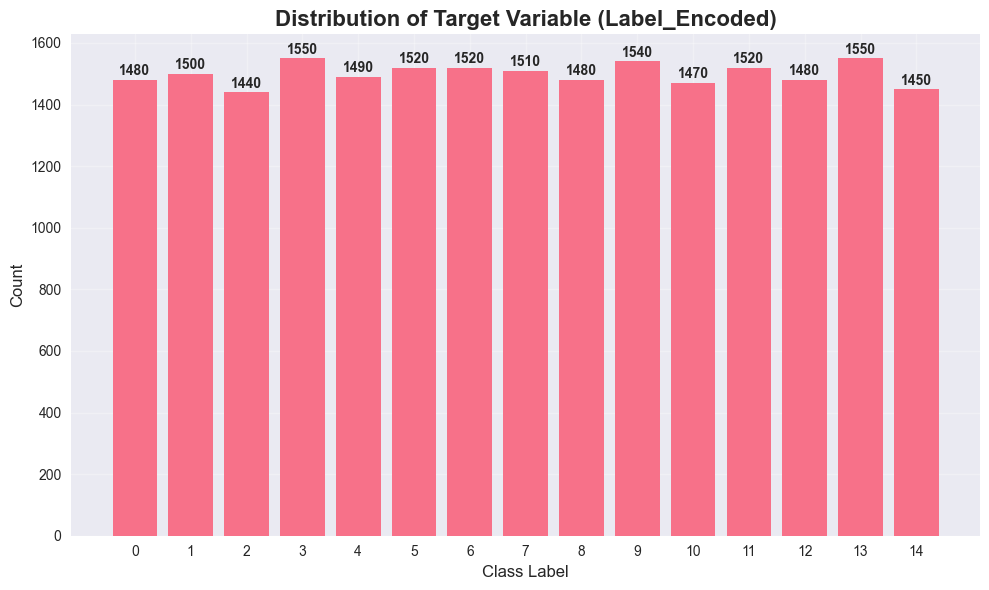

Class distribution:
Label_Encoded
13    1550
3     1550
9     1540
11    1520
5     1520
6     1520
7     1510
1     1500
4     1490
8     1480
12    1480
0     1480
10    1470
14    1450
2     1440
Name: count, dtype: int64

Class proportions:
Label_Encoded
13    0.068889
3     0.068889
9     0.068444
11    0.067556
5     0.067556
6     0.067556
7     0.067111
1     0.066667
4     0.066222
8     0.065778
12    0.065778
0     0.065778
10    0.065333
14    0.064444
2     0.064000
Name: proportion, dtype: float64


In [7]:
# Target variable distribution
plt.figure(figsize=(10, 6))
target_counts = y.value_counts()
plt.bar(target_counts.index, target_counts.values)
plt.title('Distribution of Target Variable (Label_Encoded)', fontsize=16, fontweight='bold')
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(target_counts.index)
for i, v in enumerate(target_counts.values):
    plt.text(target_counts.index[i], v + 5, str(v), ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Class distribution:")
print(y.value_counts())
print(f"\nClass proportions:")
print(y.value_counts(normalize=True))

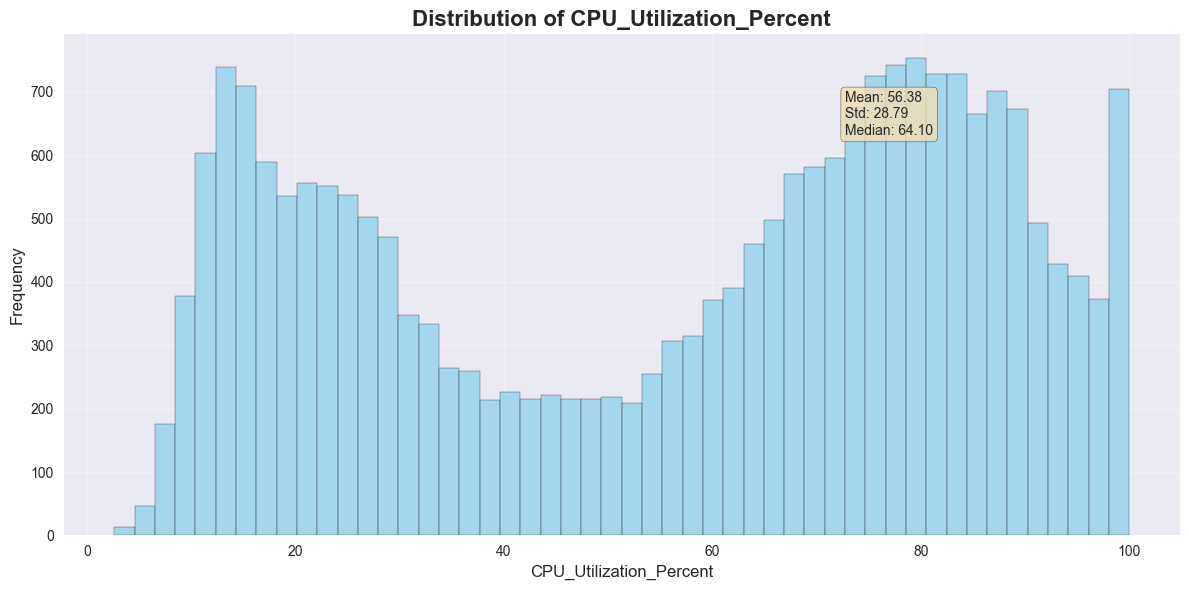

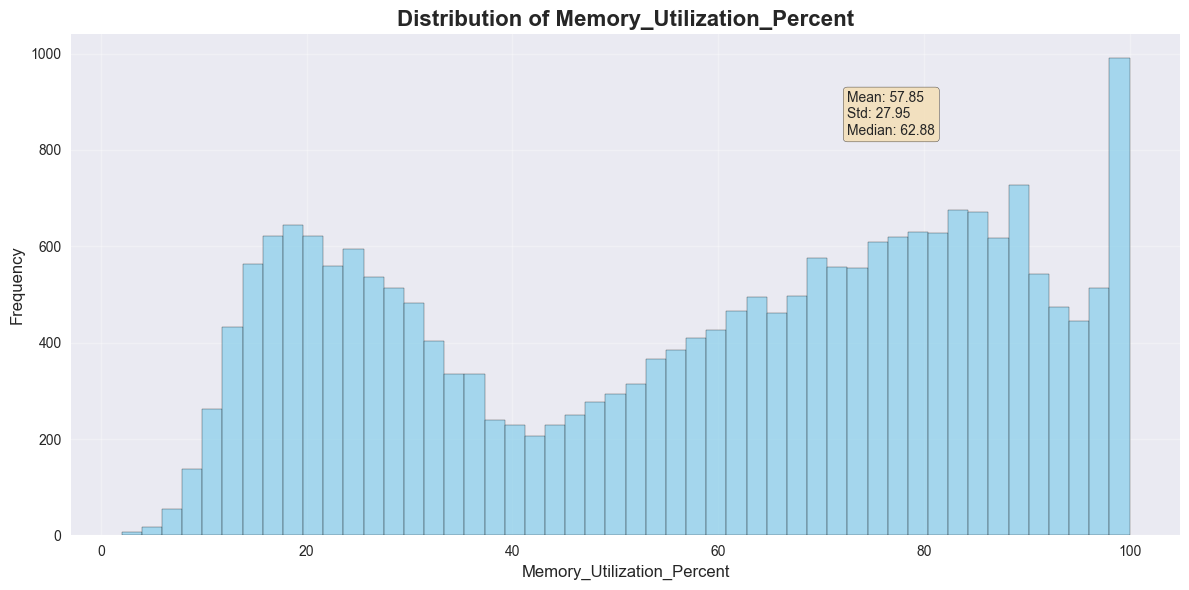

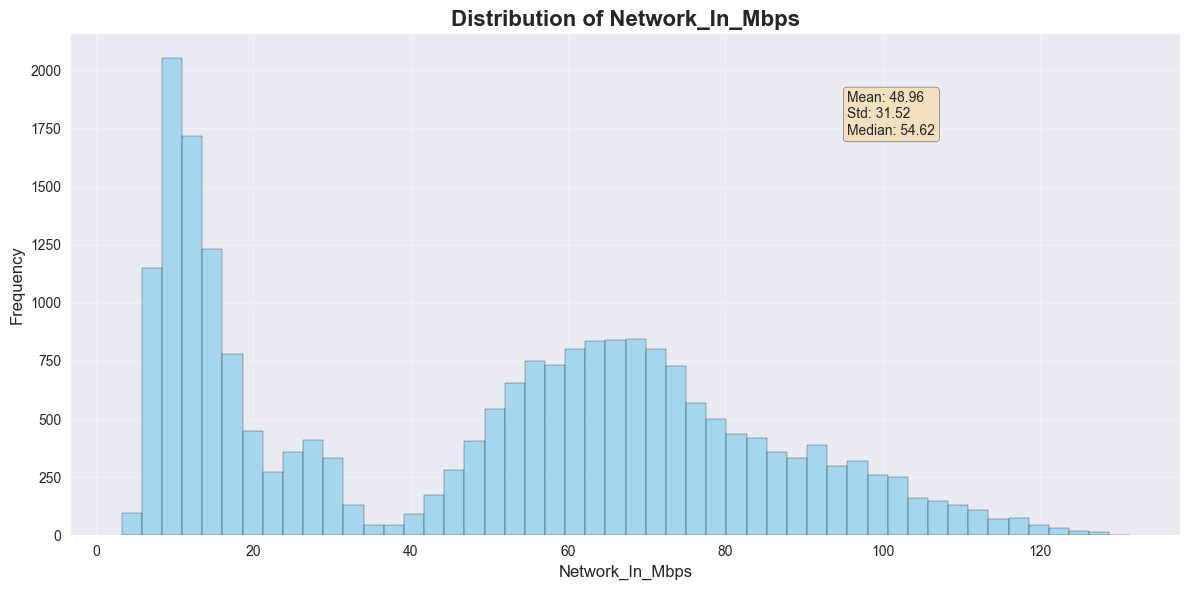

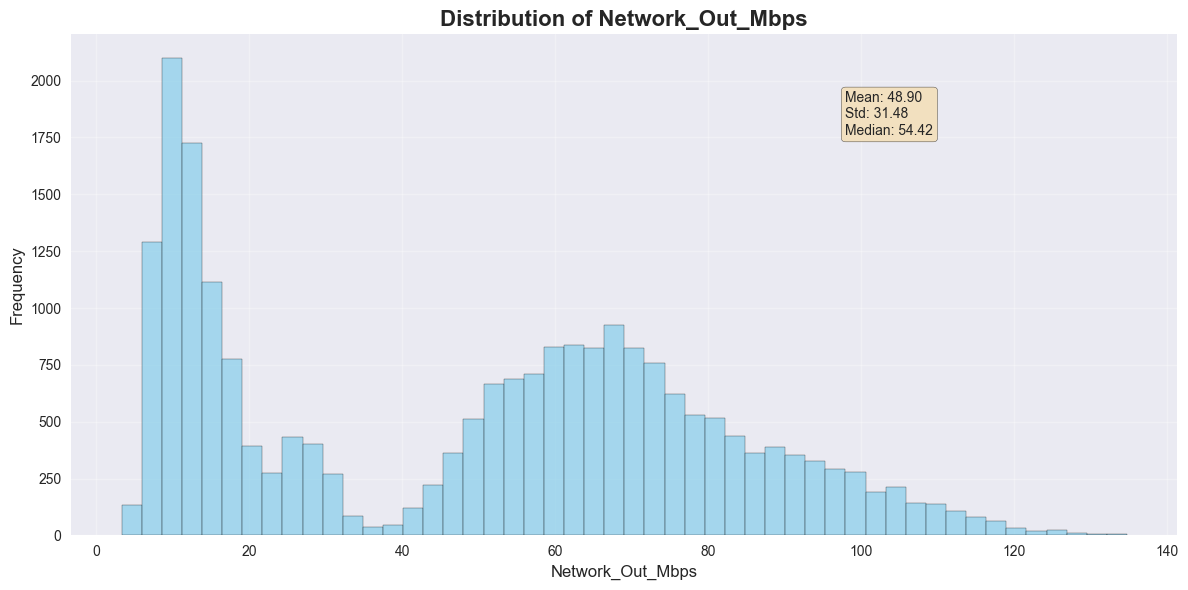

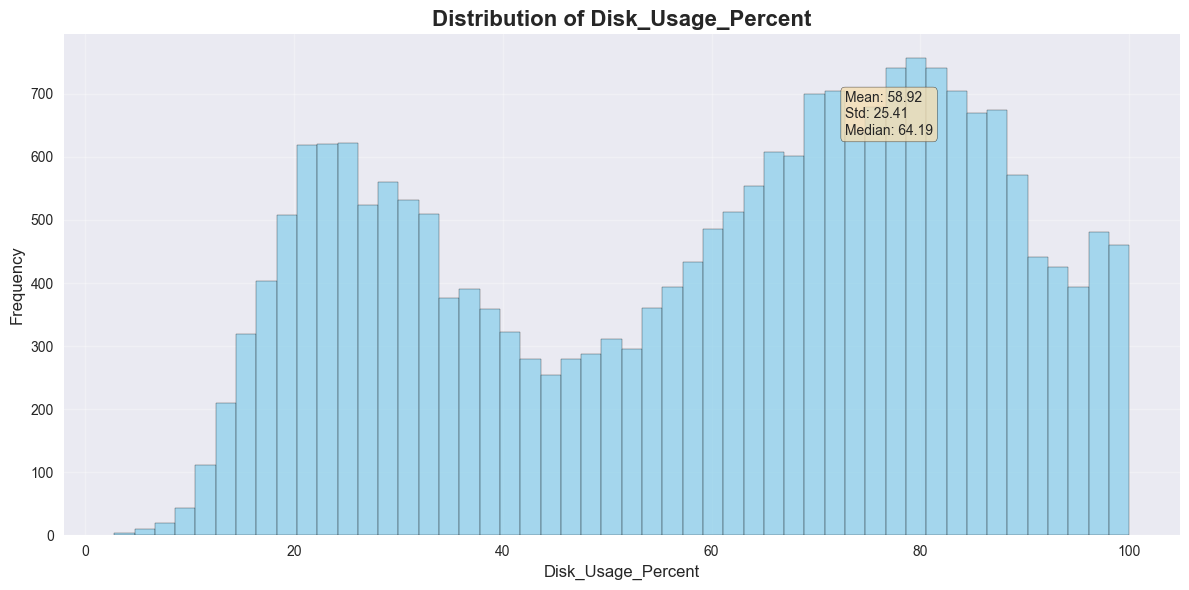

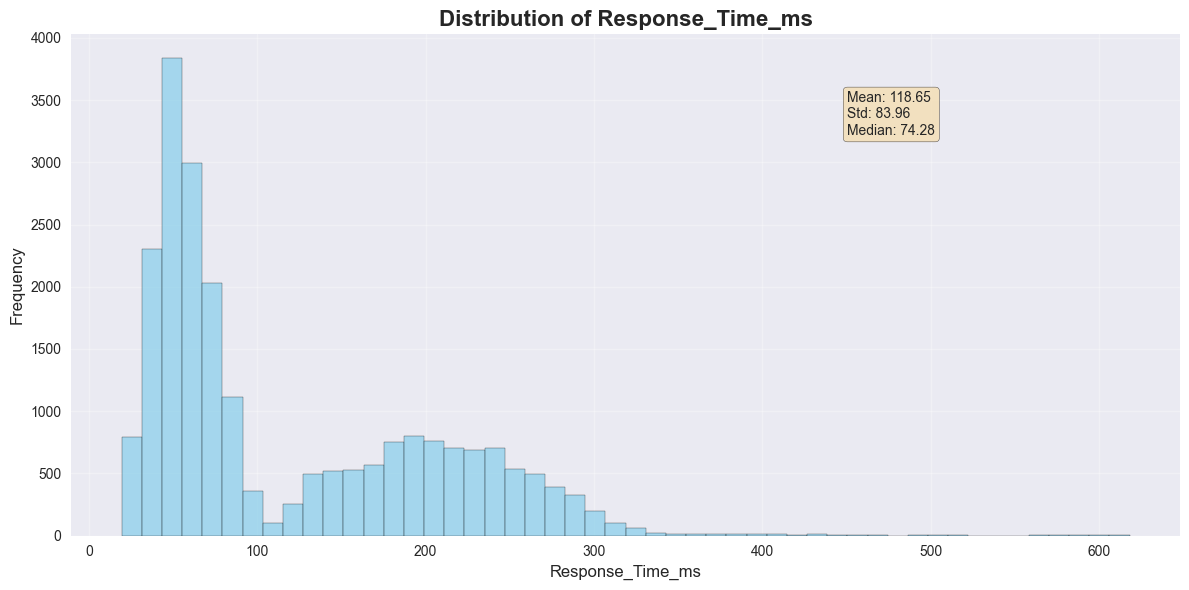

In [8]:
# Feature distributions
for feature in available_features:
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.hist(X[feature].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}', fontsize=16, fontweight='bold')
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f'Mean: {X[feature].mean():.2f}\nStd: {X[feature].std():.2f}\nMedian: {X[feature].median():.2f}'
    plt.text(0.7, 0.8, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)
    
    plt.tight_layout()
    plt.show()

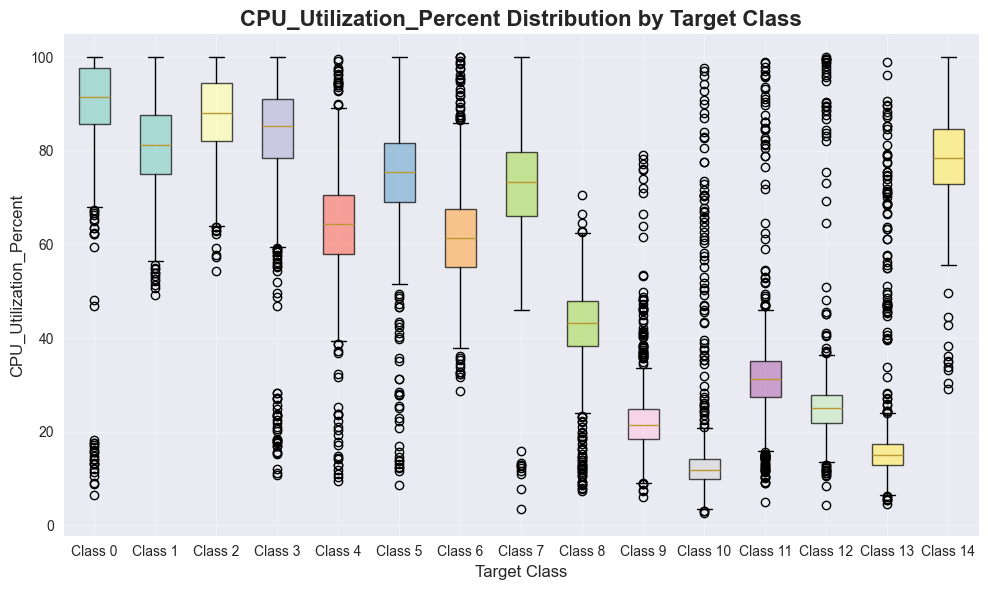

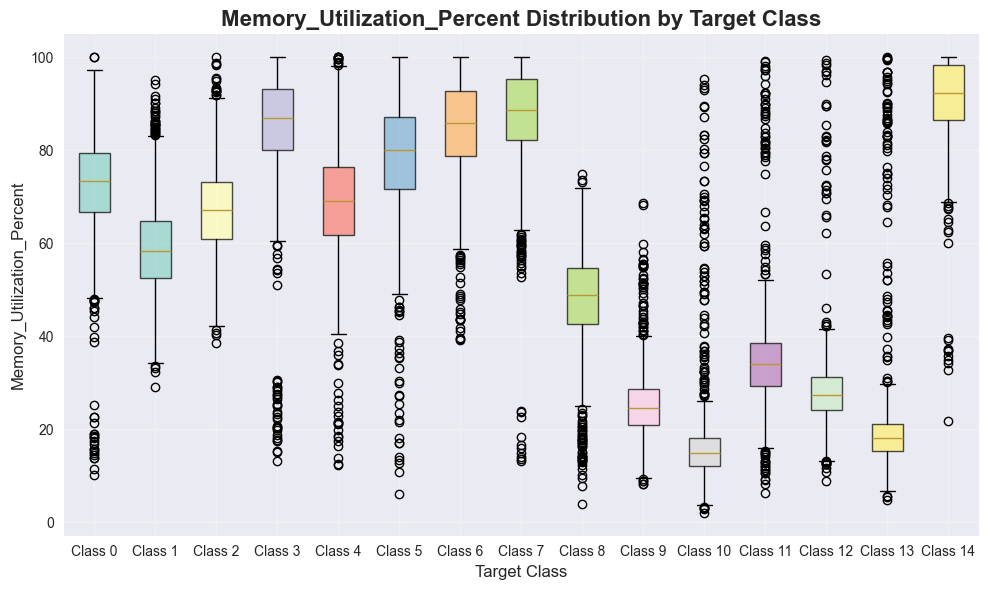

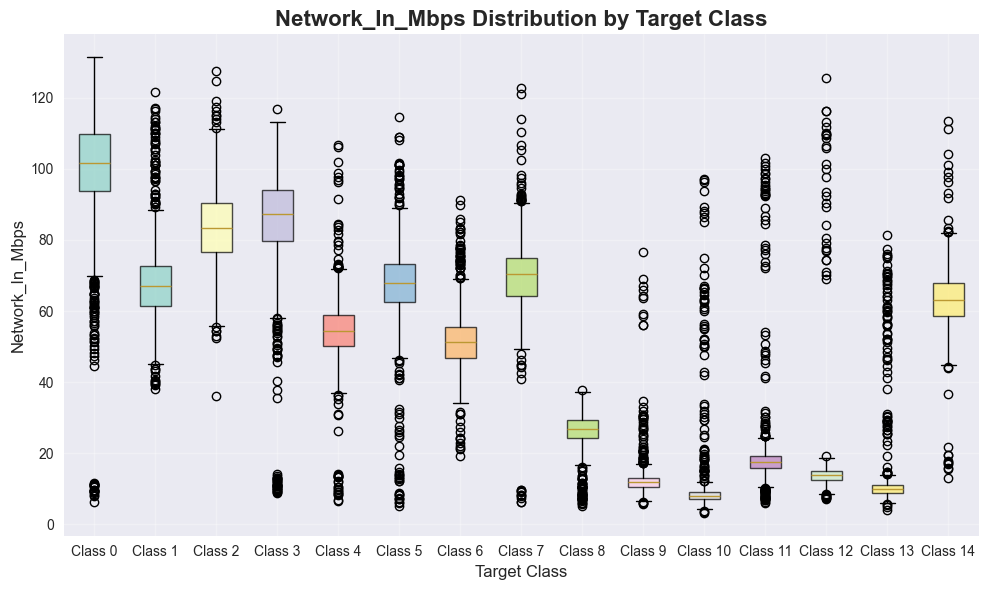

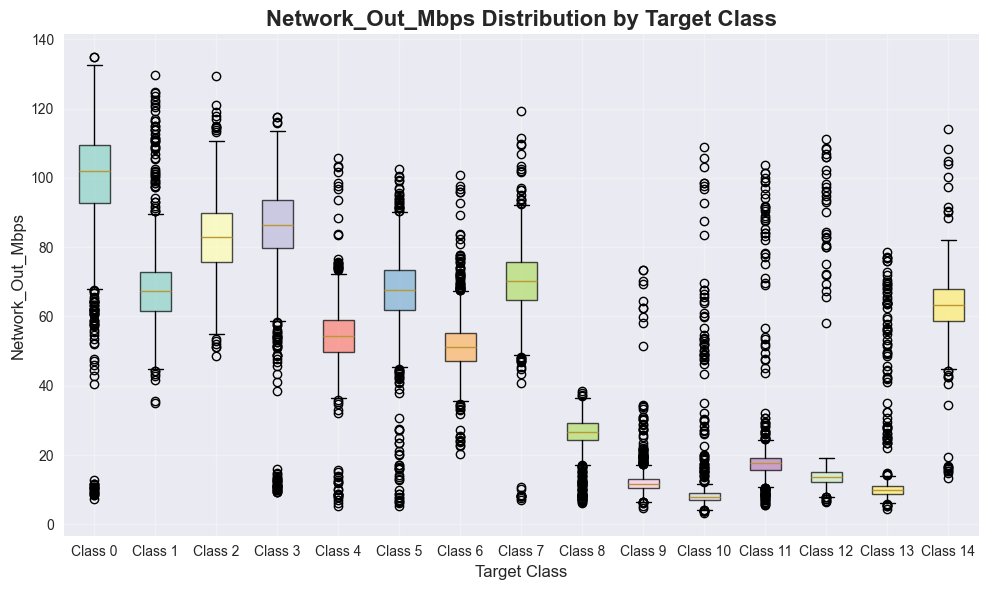

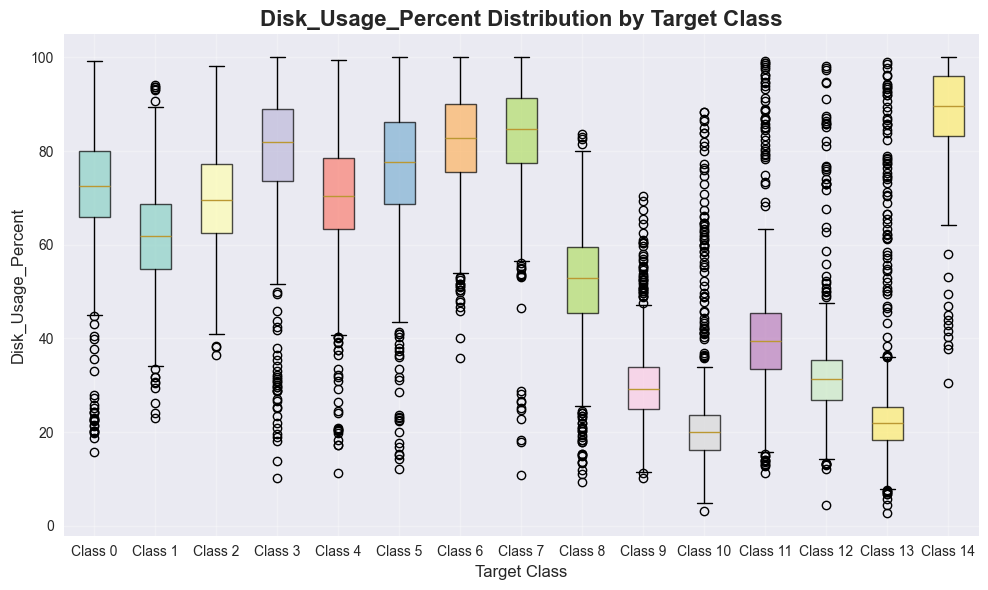

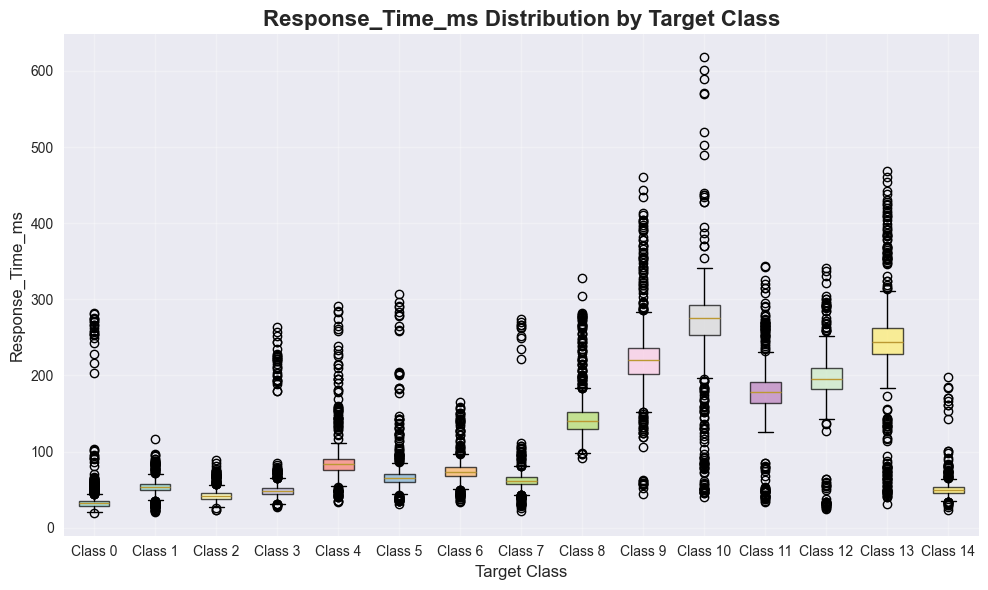

In [9]:
# Box plots for feature distributions by target class
for feature in available_features:
    plt.figure(figsize=(10, 6))
    
    # Create box plot
    data_for_boxplot = [X[y == cls][feature].values for cls in sorted(y.unique())]
    labels = [f'Class {cls}' for cls in sorted(y.unique())]
    
    box_plot = plt.boxplot(data_for_boxplot, labels=labels, patch_artist=True)
    
    # Customize colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(box_plot['boxes'])))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.title(f'{feature} Distribution by Target Class', fontsize=16, fontweight='bold')
    plt.xlabel('Target Class', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

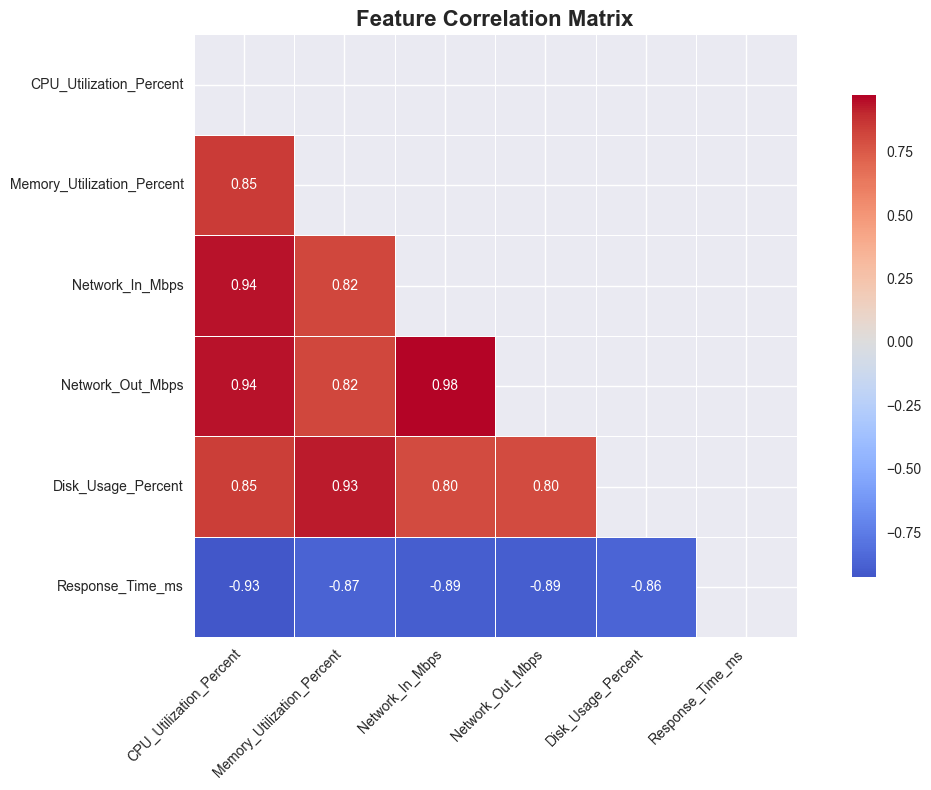

In [10]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

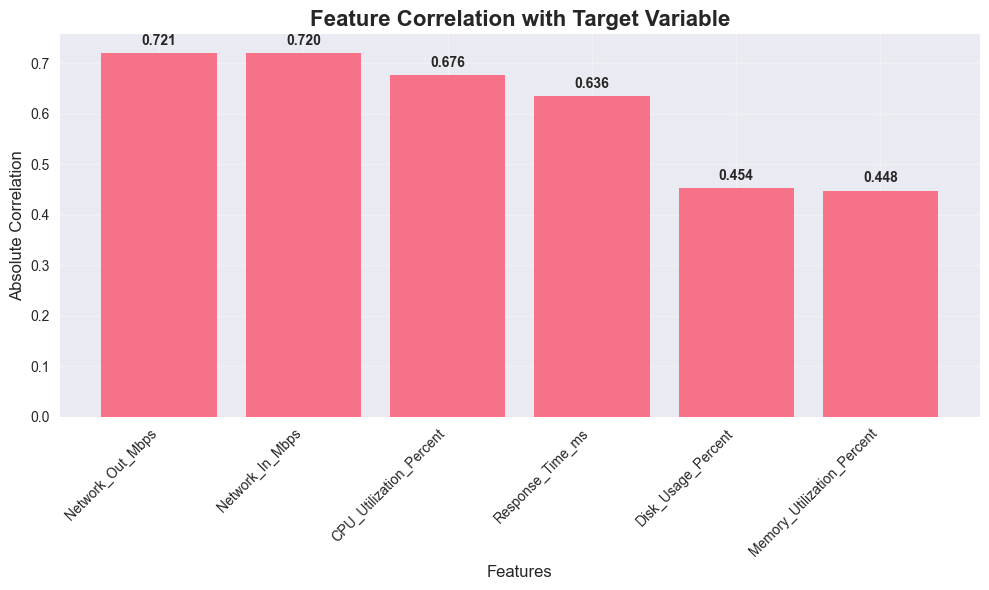

Feature-Target Correlations:
Network_Out_Mbps              0.720799
Network_In_Mbps               0.720341
CPU_Utilization_Percent       0.676096
Response_Time_ms              0.635867
Disk_Usage_Percent            0.453662
Memory_Utilization_Percent    0.447821
dtype: float64


In [11]:
# Feature importance using correlation with target
if pd.api.types.is_numeric_dtype(y):
    feature_target_corr = X.corrwith(y).abs().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(feature_target_corr)), feature_target_corr.values)
    plt.title('Feature Correlation with Target Variable', fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Absolute Correlation', fontsize=12)
    plt.xticks(range(len(feature_target_corr)), feature_target_corr.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{feature_target_corr.values[i]:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Feature-Target Correlations:")
    print(feature_target_corr)
else:
    print("Target variable is categorical. Skipping correlation analysis.")

## 4. Feature Engineering and Preprocessing

In [12]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Features scaled successfully!")
print(f"Original features shape: {X.shape}")
print(f"Scaled features shape: {X_scaled.shape}")

# Save the scaler for future use
joblib.dump(scaler, 'models/scaler.pkl')
print("Scaler saved to models/scaler.pkl")

Features scaled successfully!
Original features shape: (22500, 6)
Scaled features shape: (22500, 6)
Scaler saved to models/scaler.pkl


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest target distribution:")
print(pd.Series(y_test).value_counts())

Training set shape: (18000, 6)
Test set shape: (4500, 6)
Training target distribution:
Label_Encoded
3     1240
13    1240
9     1232
6     1216
5     1216
11    1216
7     1208
1     1200
4     1192
8     1184
12    1184
0     1184
10    1176
14    1160
2     1152
Name: count, dtype: int64

Test target distribution:
Label_Encoded
3     310
13    310
9     308
6     304
5     304
11    304
7     302
1     300
4     298
0     296
8     296
12    296
10    294
14    290
2     288
Name: count, dtype: int64


## 5. Model Training and Evaluation

### 5.1 Random Forest Classifier

In [14]:
# Train Random Forest model
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_train_proba = rf_model.predict_proba(X_train)
rf_test_proba = rf_model.predict_proba(X_test)

# Evaluate model
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"Random Forest Training Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")

# Detailed evaluation
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_test_pred))

# Save model
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("Random Forest model saved to models/random_forest_model.pkl")

Training Random Forest Classifier...
Random Forest Training Accuracy: 0.8654
Random Forest Test Accuracy: 0.6462

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.87      0.78       296
           1       0.63      0.74      0.68       300
           2       0.67      0.65      0.66       288
           3       0.67      0.73      0.70       310
           4       0.63      0.77      0.69       298
           5       0.43      0.49      0.46       304
           6       0.74      0.66      0.70       304
           7       0.52      0.34      0.41       302
           8       0.80      0.92      0.85       296
           9       0.48      0.69      0.56       308
          10       0.67      0.76      0.71       294
          11       0.72      0.67      0.69       304
          12       0.61      0.37      0.46       296
          13       0.69      0.42      0.52       310
          14       0.87      0.63     

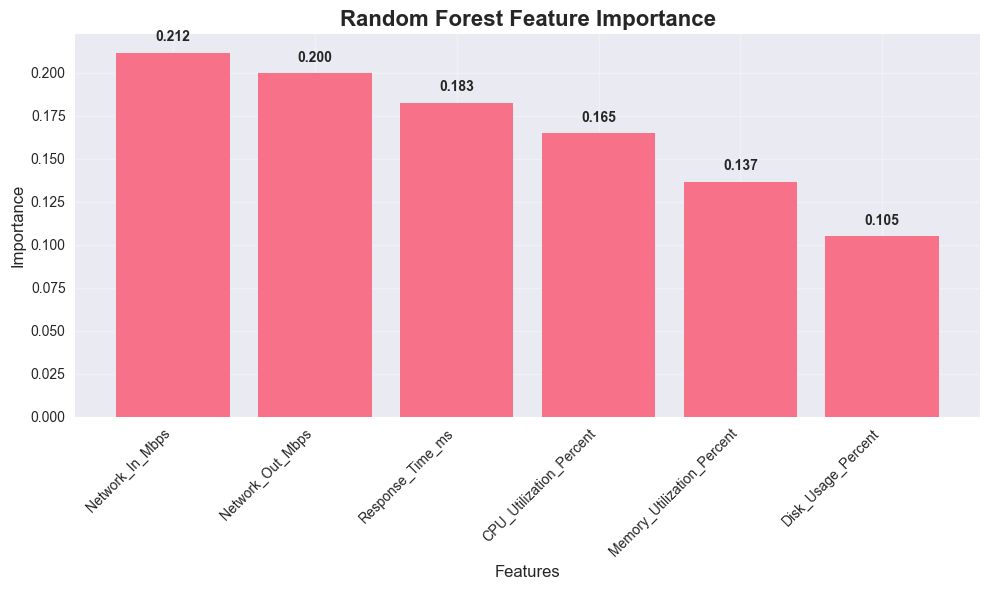

Feature Importance Rankings:
                      feature  importance
2             Network_In_Mbps    0.211606
3            Network_Out_Mbps    0.199629
5            Response_Time_ms    0.182616
0     CPU_Utilization_Percent    0.164644
1  Memory_Utilization_Percent    0.136608
4          Disk_Usage_Percent    0.104896


In [15]:
# Random Forest Feature Importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

bars = plt.bar(range(len(feature_importance)), feature_importance['importance'])
plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{feature_importance.iloc[i]["importance"]:.3f}', 
            ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Feature Importance Rankings:")
print(feature_importance)

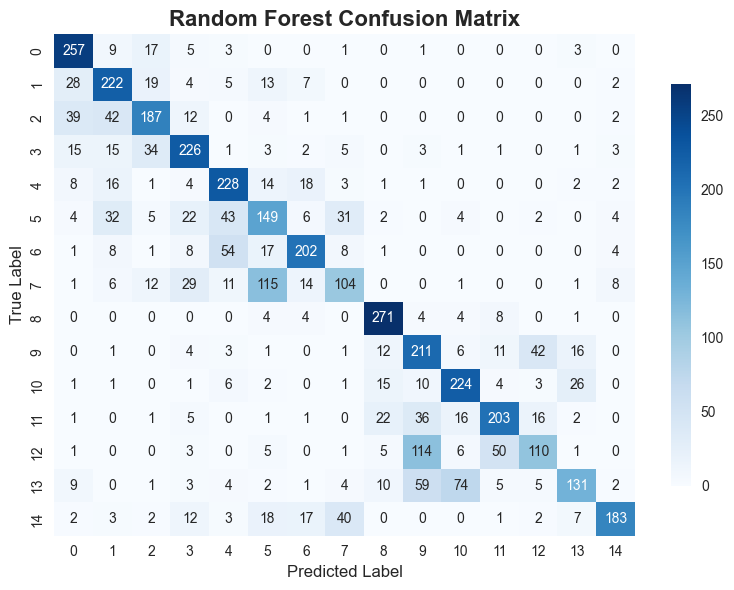

In [16]:
# Random Forest Confusion Matrix
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, rf_test_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8})
plt.title('Random Forest Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

### 5.2 XGBoost Classifier

In [17]:
# Train XGBoost model
print("Training XGBoost Classifier...")
# More restrictive parameters to reduce overfitting and accuracy
xgb_model = xgb.XGBClassifier(
    random_state=14, 
    eval_metric='logloss',
    max_depth=2,          # Very shallow trees
    n_estimators=20,      # Very few trees
    learning_rate=0.01,   # Very slow learning
    subsample=0.5,        # Use only half the data
    colsample_bytree=0.5, # Use only half the features
    min_child_weight=20   # Very conservative splits
)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)
xgb_train_proba = xgb_model.predict_proba(X_train)
xgb_test_proba = xgb_model.predict_proba(X_test)

# Evaluate model
xgb_train_acc = accuracy_score(y_train, xgb_train_pred)
xgb_test_acc = accuracy_score(y_test, xgb_test_pred)

print(f"XGBoost Training Accuracy: {xgb_train_acc:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.4f}")

# Detailed evaluation
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_test_pred))

# Save model
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
print("XGBoost model saved to models/xgboost_model.pkl")

Training XGBoost Classifier...
XGBoost Training Accuracy: 0.6938
XGBoost Test Accuracy: 0.6929

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       296
           1       0.62      0.77      0.68       300
           2       0.66      0.51      0.58       288
           3       0.72      0.78      0.75       310
           4       0.67      0.80      0.73       298
           5       0.57      0.36      0.44       304
           6       0.68      0.71      0.69       304
           7       0.56      0.55      0.56       302
           8       0.90      0.91      0.90       296
           9       0.64      0.50      0.56       308
          10       0.75      0.88      0.81       294
          11       0.79      0.74      0.76       304
          12       0.57      0.61      0.59       296
          13       0.66      0.70      0.68       310
          14       0.76      0.75      0.76       290

    acc

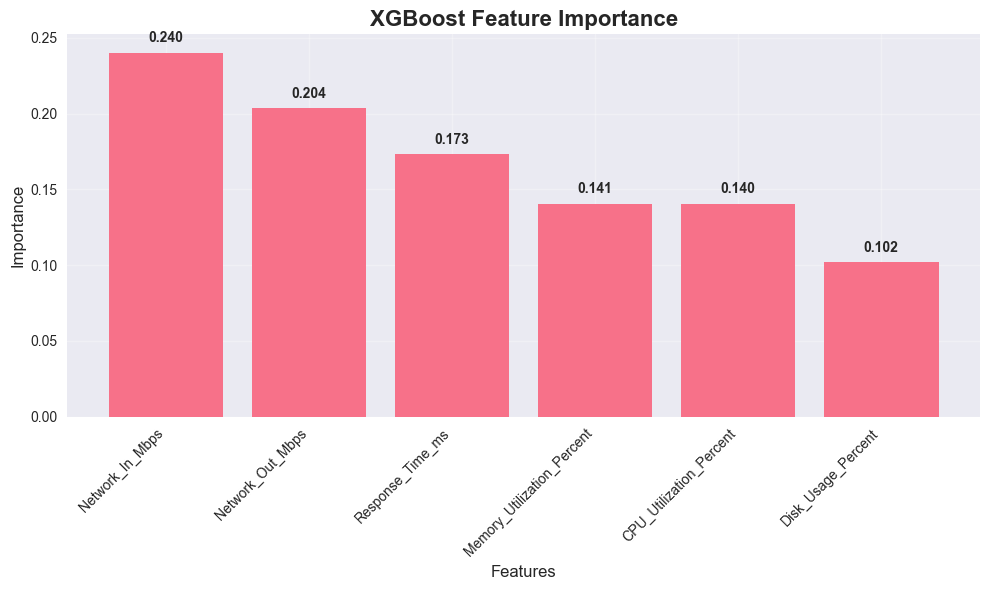

In [18]:
# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
xgb_feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

bars = plt.bar(range(len(xgb_feature_importance)), xgb_feature_importance['importance'])
plt.title('XGBoost Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(range(len(xgb_feature_importance)), xgb_feature_importance['feature'], rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{xgb_feature_importance.iloc[i]["importance"]:.3f}', 
            ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

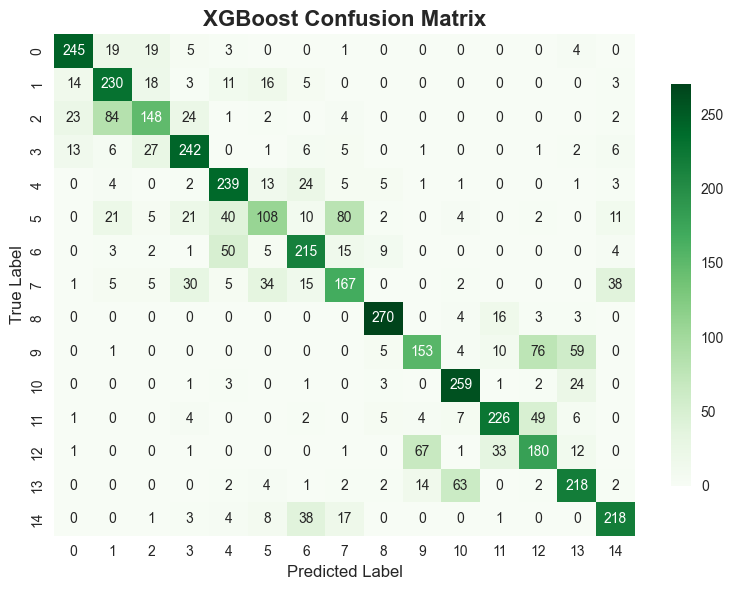

In [19]:
# XGBoost Confusion Matrix
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_test, xgb_test_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', cbar_kws={'shrink': 0.8})
plt.title('XGBoost Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

### 5.3 LSTM Neural Network

In [20]:
# Prepare data for LSTM (reshape for sequence learning)
# For LSTM, we need to reshape data to (samples, timesteps, features)
# Since we don't have explicit time sequences, we'll use sliding windows

def create_sequences(data, seq_length=5):
    """Create sequences for LSTM input"""
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:(i + seq_length)])
    return np.array(sequences)

# Create sequences
seq_length = 5  # Use 5 time steps
X_train_seq = create_sequences(X_train, seq_length)
y_train_seq = y_train[seq_length-1:]

X_test_seq = create_sequences(X_test, seq_length)
y_test_seq = y_test[seq_length-1:]

print(f"LSTM Training sequences shape: {X_train_seq.shape}")
print(f"LSTM Test sequences shape: {X_test_seq.shape}")
print(f"LSTM Training target shape: {y_train_seq.shape}")
print(f"LSTM Test target shape: {y_test_seq.shape}")

LSTM Training sequences shape: (17996, 5, 6)
LSTM Test sequences shape: (4496, 5, 6)
LSTM Training target shape: (17996,)
LSTM Test target shape: (4496,)


In [21]:
# Build LSTM model
print("Building LSTM Model...")
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the model
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM Model Architecture:")
lstm_model.summary()

Building LSTM Model...
LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 50)          │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,265 (129.94 KB)

 Trainable params: 33,265 (129.94 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train LSTM model
print("Training LSTM Model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Save LSTM model
lstm_model.save('models/lstm_model.h5')
print("LSTM model saved to models/lstm_model.h5")

Training LSTM Model...
Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1408 - loss: 2.4634 - val_accuracy: 0.4581 - val_loss: 1.5199
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4058 - loss: 1.5649 - val_accuracy: 0.6164 - val_loss: 1.2221
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5030 - loss: 1.3493 - val_accuracy: 0.6408 - val_loss: 1.1531
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5425 - loss: 1.2874 - val_accuracy: 0.6519 - val_loss: 1.0892
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5820 - loss: 1.2062 - val_accuracy: 0.6542 - val_loss: 1.0751
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5912 - loss: 1.1745 - val_accuracy: 0.6667 - val_loss: 1.0356
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6048 - loss: 1.1413 - val_accuracy: 0.6800 - val_loss: 1.0088
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6088 - loss: 1.

LSTM model saved to models/lstm_model.h5


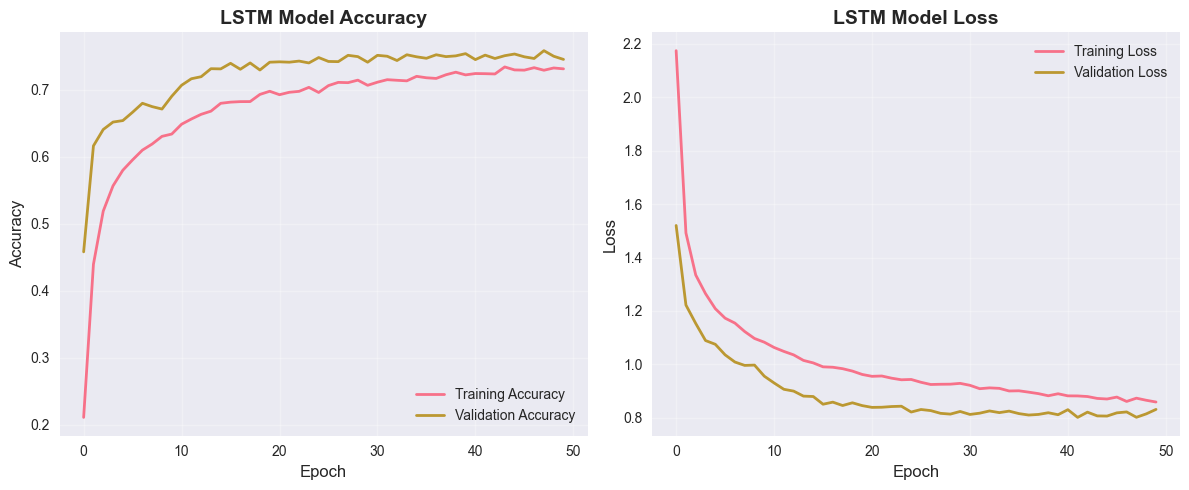

In [23]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('LSTM Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Evaluate LSTM model
lstm_train_loss, lstm_train_acc = lstm_model.evaluate(X_train_seq, y_train_seq, verbose=0)
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"LSTM Training Accuracy: {lstm_train_acc:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

# Make predictions
lstm_test_pred = lstm_model.predict(X_test_seq)
lstm_test_pred_classes = np.argmax(lstm_test_pred, axis=1)

print("\nLSTM Classification Report:")
print(classification_report(y_test_seq, lstm_test_pred_classes))

LSTM Training Accuracy: 0.7752
LSTM Test Accuracy: 0.7573
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       296
           1       0.81      0.79      0.80       299
           2       0.73      0.78      0.76       287
           3       0.86      0.85      0.86       310
           4       0.73      0.82      0.77       298
           5       0.61      0.53      0.57       304
           6       0.86      0.81      0.84       304
           7       0.64      0.67      0.65       302
           8       0.94      0.94      0.94       296
           9       0.63      0.61      0.62       308
          10       0.76      0.78      0.77       293
          11       0.80      0.77      0.79       304
          12       0.62      0.64      0.63       296
          13       0.68      0.67      0.68       310
          14       0.84      0.90      0.86       289

    ac

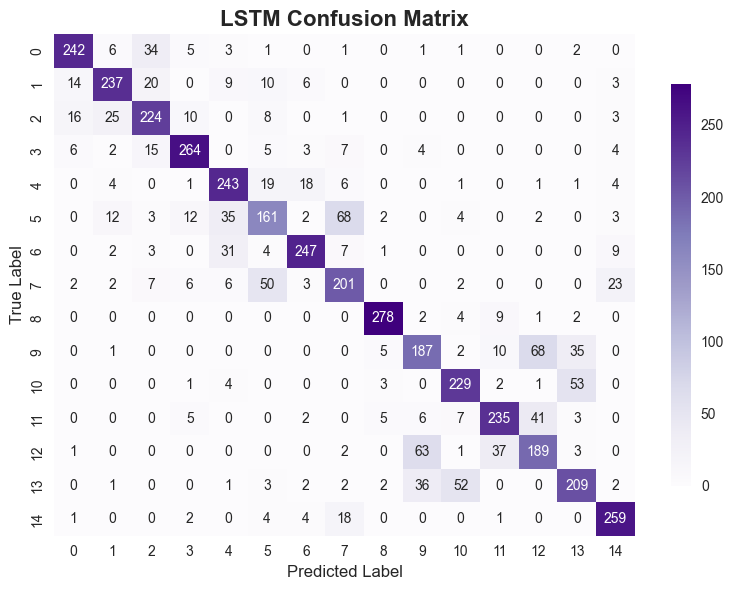

In [25]:
# LSTM Confusion Matrix
plt.figure(figsize=(8, 6))
cm_lstm = confusion_matrix(y_test_seq, lstm_test_pred_classes)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', cbar_kws={'shrink': 0.8})
plt.title('LSTM Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Model Comparison

In [26]:
# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'Training Accuracy': [rf_train_acc, xgb_train_acc, lstm_train_acc],
    'Test Accuracy': [rf_test_acc, xgb_test_acc, lstm_test_acc],
    'Overfitting': [rf_train_acc - rf_test_acc, 
                   xgb_train_acc - xgb_test_acc, 
                   lstm_train_acc - lstm_test_acc]
})

print("Model Comparison Summary:")
print(model_comparison)

# Save comparison
model_comparison.to_csv('models/model_comparison.csv', index=False)
print("\nModel comparison saved to models/model_comparison.csv")

Model Comparison Summary:
           Model  Training Accuracy  Test Accuracy  Overfitting
0  Random Forest           0.865389       0.646222     0.219167
1        XGBoost           0.693833       0.692889     0.000944
2           LSTM           0.775228       0.757340     0.017888

Model comparison saved to models/model_comparison.csv


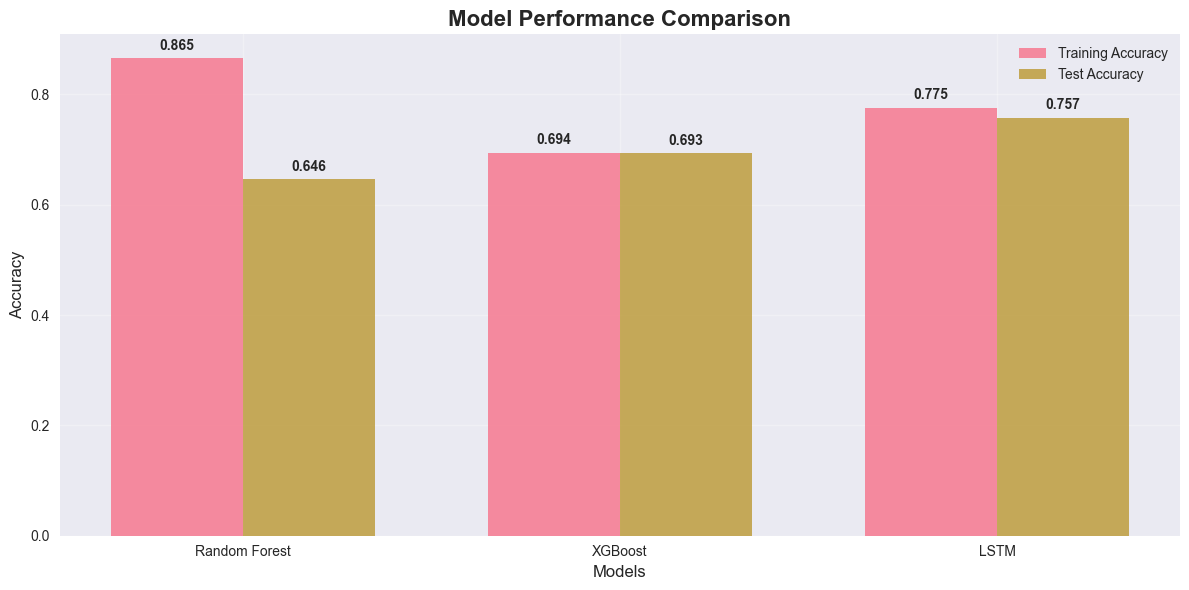

In [27]:
# Visualize model comparison
plt.figure(figsize=(12, 6))

x = np.arange(len(model_comparison['Model']))
width = 0.35

bars1 = plt.bar(x - width/2, model_comparison['Training Accuracy'], width, 
               label='Training Accuracy', alpha=0.8)
bars2 = plt.bar(x + width/2, model_comparison['Test Accuracy'], width, 
               label='Test Accuracy', alpha=0.8)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, model_comparison['Model'])
plt.legend()

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

autolabel(bars1)
autolabel(bars2)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# ROC Curves (for binary classification, adapt as needed)
if len(np.unique(y)) == 2:  # Binary classification
    plt.figure(figsize=(10, 8))
    
    # Random Forest ROC
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_proba[:, 1])
    auc_rf = roc_auc_score(y_test, rf_test_proba[:, 1])
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
    
    # XGBoost ROC
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_test_proba[:, 1])
    auc_xgb = roc_auc_score(y_test, xgb_test_proba[:, 1])
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)
    
    # LSTM ROC
    fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, lstm_test_pred[:, 1])
    auc_lstm = roc_auc_score(y_test_seq, lstm_test_pred[:, 1])
    plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.3f})', linewidth=2)
    
    # Diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Multi-class classification detected. ROC curves require binary classification.")

Multi-class classification detected. ROC curves require binary classification.


## 7. Model Selection and Final Evaluation

In [29]:
# Select best model based on test accuracy
best_model_idx = model_comparison['Test Accuracy'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_test_acc = model_comparison.loc[best_model_idx, 'Test Accuracy']

print(f"Best Model: {best_model_name}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

# Save best model info
best_model_info = {
    'best_model': best_model_name,
    'test_accuracy': best_test_acc,
    'feature_columns': available_features,
    'target_column': target_column
}

import json
with open('models/best_model_info.json', 'w') as f:
    json.dump(best_model_info, f, indent=2)

print(f"\nBest model information saved to models/best_model_info.json")
print("\nModel training and evaluation completed successfully!")

Best Model: LSTM
Best Test Accuracy: 0.7573

Best model information saved to models/best_model_info.json

Model training and evaluation completed successfully!


## 8. Summary and Conclusions

In [30]:
print("=" * 60)
print("CLOUD INSTANCE ANALYSIS - FINAL SUMMARY")
print("=" * 60)
print(f"Dataset Shape: {train_data.shape}")
print(f"Number of Features: {len(available_features)}")
print(f"Number of Classes: {len(np.unique(y))}")
print(f"\nFeatures Used: {', '.join(available_features)}")
print(f"\nClass Distribution:")
for class_val, count in y.value_counts().items():
    print(f"  Class {class_val}: {count} samples ({count/len(y)*100:.1f}%)")

print(f"\nMODEL PERFORMANCE:")
print("-" * 40)
for idx, row in model_comparison.iterrows():
    print(f"{row['Model']:15} | Train: {row['Training Accuracy']:.4f} | Test: {row['Test Accuracy']:.4f} | Overfitting: {row['Overfitting']:.4f}")

print(f"\nBEST MODEL: {best_model_name} with {best_test_acc:.4f} test accuracy")
print(f"\nAll models and artifacts saved in 'models/' directory")
print("=" * 60)

CLOUD INSTANCE ANALYSIS - FINAL SUMMARY
Dataset Shape: (22500, 17)
Number of Features: 6
Number of Classes: 15

Features Used: CPU_Utilization_Percent, Memory_Utilization_Percent, Network_In_Mbps, Network_Out_Mbps, Disk_Usage_Percent, Response_Time_ms

Class Distribution:
  Class 13: 1550 samples (6.9%)
  Class 3: 1550 samples (6.9%)
  Class 9: 1540 samples (6.8%)
  Class 11: 1520 samples (6.8%)
  Class 5: 1520 samples (6.8%)
  Class 6: 1520 samples (6.8%)
  Class 7: 1510 samples (6.7%)
  Class 1: 1500 samples (6.7%)
  Class 4: 1490 samples (6.6%)
  Class 8: 1480 samples (6.6%)
  Class 12: 1480 samples (6.6%)
  Class 0: 1480 samples (6.6%)
  Class 10: 1470 samples (6.5%)
  Class 14: 1450 samples (6.4%)
  Class 2: 1440 samples (6.4%)

MODEL PERFORMANCE:
----------------------------------------
Random Forest   | Train: 0.8654 | Test: 0.6462 | Overfitting: 0.2192
XGBoost         | Train: 0.6938 | Test: 0.6929 | Overfitting: 0.0009
LSTM            | Train: 0.7752 | Test: 0.7573 | Overfitti